In [65]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import math
import os
plt.rcParams['figure.figsize'] = (10, 10)

In [40]:
#Funciones Auxiliares
def sumaV(x,y):
    '''Suma 2 vectores dados'''
    a,b=x
    c,d=y
    return (a+c,b+d)
def multV(n,a):
    '''Multiplica un vector a por una constante n'''
    a1,a2 = a
    return (a1*n,a2*n)
def m2V(n,m,s):
    a,b=s
    return sumaV(multV(a,n),multV(b,m))
def rota(vect, theta):
    '''Rota un vector en un ángulo en Theta grados'''
    ang = float((theta/180.0)*math.pi)
    (x,y) = vect
    vr = ((math.cos(ang)*x)-(math.sin(ang)*y), (math.sin(ang)*x)+(math.cos(ang)*y))
    return vr
def getLim(u,v,m,n):
    (a1,a2) = multV(m,u)
    (b1,b2) = multV(n,v)
    (c1,c2) = m2V(u,v,(m,n))
    ma=max(a1,a2,b1,b2,c1,c2,0)
    mi=min(a1,a2,b1,b2,c1,c2,0)
    return mi-1, ma+1

In [3]:
class Atomo:
    '''Clase que define un atomo en el sistema'''
    def __init__(self, pos, color='black'):
        '''Inicializa el objeto Atomo usando como entradas su posición (x,y) pos y su color caracteristico color'''
        self.pos = pos
        self.color = color
        self.enlaces = []

    def printAtomo(self, r, axs):
        '''Imprime un Atomo en un Patch en el axs señalado'''
        axs.add_patch(plt.Circle((self.pos), r , color=self.color))

    def setEnlace(self, atm):
        '''Enlaza 2 Atomos'''
        self.enlaces.append(atm)
        atm.enlaces.append(self)
        return 1


In [68]:
class Malla:
    def __init__(self, u, v, theta = 0.0, atms=[]):
        self.OriginalU = u
        self.OriginalV = v
        if theta==0.0:
            self.u = u
            self.v = v
        else:
            self.u = rota(u,theta)
            self.v = rota(v,theta)
        self.atms = atms
    
    def showNM(self, n, m, t=10,name=''):
        mi,ma=getLim(self.u,self.v,n,m)
        ats=[]
        col=[]
        enls=[]
        s1,s2=1,1
        if n<0:
            s1=-1
        if m<0:
            s2=-1
        for i in range(abs(n)):
            a=i*s1
            for j in range(abs(m)):
                b=j*s2
                for c in self.atms:
                    for (at,enl) in c:
                        (pu,pv) = at.pos
                        na = m2V(self.u,self.v,(a+pu,b+pv))
                        ats.append(na)
                        col.append(at.color)
                        for (ei,ef) in enl:
                            (ei1,ei2) = ei
                            (ef1,ef2) = ef
                            o = m2V(self.u,self.v,(a+ei1,b+ei2))
                            f = m2V(self.u,self.v,(a+ef1,b+ef2))
                            #print(m2V(self.u,self.v,(a+ei1,b+ei2)),m2V(self.u,self.v,(a+ef1,b+ef2)))
                            enls.append([o,f])
        fig, axs = plt.subplots()
        lis = np.array(ats)
        xs, ys = lis[:,0], lis[:,1]
        axs.scatter(xs,ys, color=col,s=t)
        lc = mc.LineCollection(np.array(enls), colors='black', linewidths=(t/10))
        axs.add_collection(lc)
        axs.axes.xaxis.set_visible(False)
        axs.axes.yaxis.set_visible(False)
        axs.set(xlim=(mi,ma), ylim = (mi,ma))
        if name!='':
            plt.savefig(name,dpi=900, bbox_inches='tight')
        plt.show()
        return 1
    
    def showData(self):
        (u1,u2) = self.u
        (v1,v2) = self.v
        data='''New structure
1.0
        {:.10f}         {:.10f}         0.0000000000
        {:.10f}         {:.10f}         0.0000000000
        0.0000000000         0.0000000000         {:.10f}
'''.format(u1,u2,v1,v2,(len(self.atms)+1))
        atms1=""
        atms2=""
        atms3="Direct"
        for i in range(len(self.atms)):
            atms1=atms1+"    A{}".format(i+1)
            atms2=atms2+"    {}".format(len(self.atms[i]))
            for (a,en) in self.atms[i]:
                (x,y)=a.pos
                atms3=atms3+"\n     {:.10f}         {:.10f}         {:.10f}".format(x,y,i)
        atms = atms1+"\n"+atms2+"\n"+atms3
        data = data+atms
        return data
    def exporta(self,name):
        name=name+".vasp"
        f = open(name,"w")
        f.write(self.showData())
        f.close()
        return 1

In [53]:
def isitin(m,cent, mu, mv):
    res = []
    inUnit = False
    (u1,u2) = m.u
    (v1,v2) = m.v
    (p1,p2) = mu
    (q1,q2) = mv
    eq0 = (p2*q1)-(p1*q2)
    eq1 = (q1*u2)-(q2*u1)
    eq2 = (q1*v2)-(q2*v1)
    eq3 = (p2*u1)-(p1*u2)
    eq4 = (p2*v1)-(p1*v2)
    for c in m.atms:
        nc=[]
        for (a,enl) in c:
            (x,y) = sumaV(cent,a.pos)
            nx = (eq1*x+eq2*y)/eq0
            ny = (eq3*x+eq4*y)/eq0
            nAtm=Atomo((nx,ny),color=a.color)
            if (nx<1 and nx>0) and (ny<1 and ny>0):
                nEnl = []
                for e in enl:
                    (x1,y1) = sumaV(cent,e[0])
                    (x2,y2) = sumaV(cent,e[1])
                    o = ((eq1*x1+eq2*y1)/eq0,(eq3*x1+eq4*y1)/eq0)
                    f = ((eq1*x2+eq2*y2)/eq0,(eq3*x2+eq4*y2)/eq0)
                    nEnl.append([o,f])
                nc.append((nAtm,nEnl))
                inUnit = True 
        res.append(nc)
    return res, inUnit

    

In [69]:
u,v=(2.44,0.0),(1.22,math.sqrt(3)*1.22)
p1=(1/3,1/3)
p2=(2/3,2/3)
p3=(1/3,4/3)
p4=(4/3,1/3)
a1=Atomo(p1)
a2=Atomo(p2, color='blue')
ats = [[(a1,[(p1,p2)]),(a2,[(p2,p4),(p2,p3)])]]
malla=Malla(u,v,atms=ats)

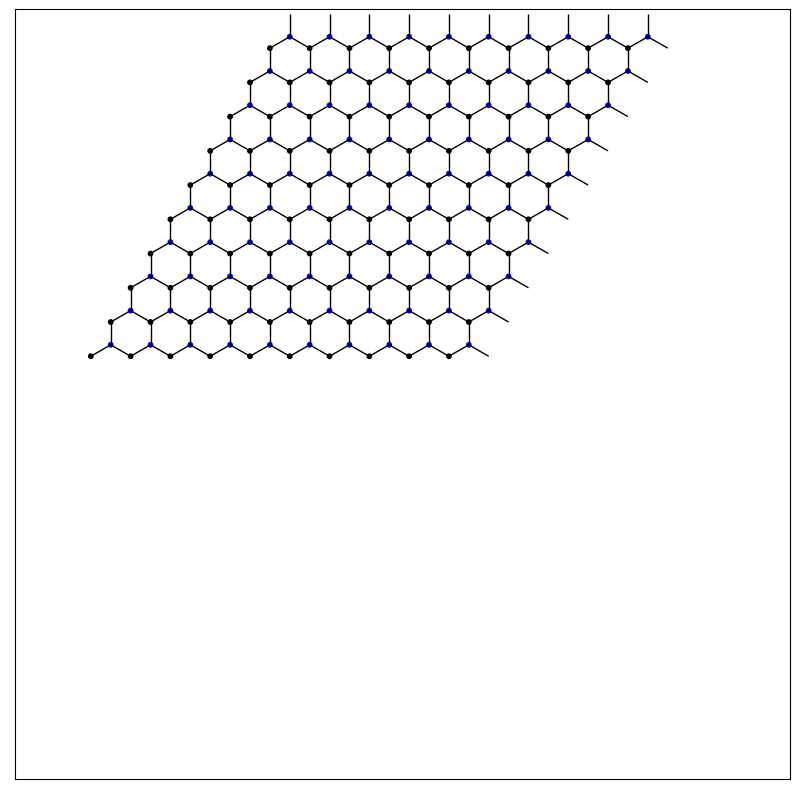

1

In [71]:
#malla.exporta("Ejemplo1")
malla.showNM(-10,10)